In [1]:
# Imports
import numpy as np
import random
import pickle
import os

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, LSTM, TimeDistributed, Dropout
from keras.optimizers import RMSprop
from keras.models import Sequential, load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Parameters

max_length = 120

epochs = 100
batch_size = 256

In [4]:

def get_bills(nb_bills=24, mix=True):
    
    all_bills = os.listdir(os.path.join('..', 'data'))
    
    if mix:
    
        return random.sample(all_bills, nb_bills)
    
    else:
        
        return all_bills[:nb_bills]


In [5]:
# Load Data

def load_data(bills, max_length=max_length, step=1):

    chars = set()

    sequences, next_chars = [], []

    for bill_fn in bills:

        with open(os.path.join('..', 'data', bill_fn), 'r') as bill_file:
            bill = bill_file.read()

        chars |= set(bill)

        for i in range(0, len(bill) - max_length, step):
            sequences.append(bill[i: i + max_length])
            next_chars.append(bill[i + max_length])

        sequences.append(bill[-max_length:])
        next_chars.append('*END*')

    chars = sorted(list(chars)) + ['*END*']
    chr_to_int = dict((c, i) for i, c in enumerate(chars))
    int_to_chr = dict((i, c) for i, c in enumerate(chars))
    
    return (sequences, next_chars), (len(chars), chr_to_int, int_to_chr)


In [6]:
# Process Data

def process_data(sequences, next_chars, num_chars, chr_to_int):

    X = np.zeros((len(sequences), max_length, num_chars), dtype=np.bool)
    y = np.zeros((len(sequences), num_chars), dtype=np.bool)
    
    for i, sequence in enumerate(sequences):
        
        for j, char in enumerate(sequence):
            
            X[i, j, chr_to_int[char]] = 1
            
        y[i, chr_to_int[next_chars[i]]] = 1
        
    return X, y


In [7]:
# Get Model

def get_model(num_chars, max_length=max_length):

    model = Sequential()

    model.add(LSTM(512, input_shape=(max_length, num_chars), return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(0.5))

    model.add(Dense(num_chars))

    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001))
    
    return model
    

In [8]:

def sample(preds, temperature=1.0):
    
    preds = np.asarray(preds).astype('float64')
    
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    probas = np.random.multinomial(1, preds, 1)
    
    return np.argmax(probas)


In [9]:
# (Run) Load Data

if __name__ == "__main__":
    
    bills = get_bills()
    
    (sequences, next_chars), (num_chars, chr_to_int, int_to_chr) = load_data(bills)
    
    with open(os.path.join('..', 'models', 'char-table.pickle'), 'wb') as table_file:
        pickle.dump(chr_to_int, table_file)
    
    X, y = process_data(sequences, next_chars, num_chars, chr_to_int)
    
    print(X.shape, y.shape)


(168512, 120, 80) (168512, 80)


Train on 122848 samples, validate on 13650 samples
Epoch 1/100
122848/122848 [==============================] - 389s - loss: 3.5358 - val_loss: 3.2648
Epoch 2/100
122848/122848 [==============================] - 384s - loss: 2.8783 - val_loss: 2.4043
Epoch 3/100
122848/122848 [==============================] - 384s - loss: 2.1707 - val_loss: 1.9252
Epoch 4/100
122848/122848 [==============================] - 381s - loss: 1.8235 - val_loss: 1.6678
Epoch 5/100
122848/122848 [==============================] - 382s - loss: 1.5723 - val_loss: 1.5270
Epoch 6/100
122848/122848 [==============================] - 383s - loss: 1.4046 - val_loss: 1.4118
Epoch 7/100
122848/122848 [==============================] - 385s - loss: 1.3673 - val_loss: 1.3157
Epoch 8/100
122848/122848 [==============================] - 382s - loss: 1.2507 - val_loss: 1.8415
Epoch 9/100
122848/122848 [==============================] - 384s - loss: 1.6380 - val_loss: 1.4752
Epoch 10/100
122848/122848 [=====================

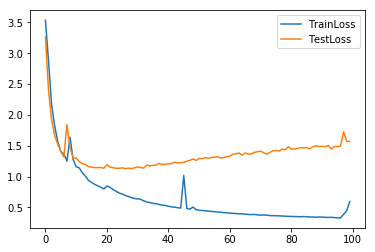

In [9]:
# (Run) Train

if __name__ == "__main__":
    
    model = get_model(num_chars)
    
    save1 = ModelCheckpoint(os.path.join('..', 'models', 'bill-gen.h5'), # This will prob be overfit but could still be useful
                            monitor='loss',
                            verbose=0,
                            save_best_only=True)
    
    save2 = ModelCheckpoint(os.path.join('..', 'models', 'bill-gen2.h5'), 
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True)
    
    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=.1,
                        verbose=1,
                        callbacks=[save1, save2])
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()


In [14]:

def generate_bill():
    
    model = load_model(os.path.join('..', 'models', 'bill-gen2.h5'))

    bill_fn = random.choice(os.listdir(os.path.join('..', 'data')))

    with open(os.path.join('..', 'data', bill_fn), 'r') as bill_file:
        rand_bill = bill_file.read()

    new_bill = rand_bill[:max_length]
    print("Starting w/:\n" + new_bill)

    for i in range(15000):

        X = np.zeros((1, max_length, num_chars))

        for t, char in enumerate(new_bill[-max_length:]):
            X[0, t, chr_to_int[char]] = 1

        preds = model.predict(X, verbose=0)[0]
        next_index = sample(preds, .6)

        if int_to_chr[next_index] != '*END*' or "body" == new_bill[-4:]:
            new_bill += int_to_chr[next_index]
        else:
            break

    with open('test.html', 'w') as bill_file:
        bill_file.write(new_bill)



In [15]:

if __name__ == "__main__":
    
    generate_bill()


Starting w/:
<body><p>HR 1357 IH</p><p/><center><p>114th CONGRESS</p></center>
<p/><center><p>1st Session</p></center>
<p/><center><p


H:\Users\Shriv\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
